In [1]:
import scanpy as sc
import pandas as pd 
import numpy as np
import sys
import matplotlib.pyplot as plt
import gc
import anndata
from adjustText import adjust_text
from scipy.stats import median_abs_deviation

def gen_mpl_labels(adata, groupby, exclude=(), ax=None, adjust_kwargs=None, text_kwargs=None, offset=(0.05, 0.05)):
    if adjust_kwargs is None:
        adjust_kwargs = {
            "arrowprops": {"arrowstyle": "--->", "color": 'r'}, 
            "expand_points": (1.2, 1.2), 
            "force_points": 0.5
        }
    if text_kwargs is None:
        text_kwargs = {}

    highest_density_points = {}

    for g, g_idx in adata.obs.groupby(groupby).groups.items():
        if g in exclude:
            continue
        points = adata[g_idx].obsm["X_umap"]
        hist, xedges, yedges = np.histogram2d(points[:, 0], points[:, 1], bins=[50, 50])
        max_bin = np.unravel_index(np.argmax(hist), hist.shape)
        highest_density_point = [
            (xedges[max_bin[0]] + xedges[max_bin[0]+1])/2 + offset[0], 
            (yedges[max_bin[1]] + yedges[max_bin[1]+1])/2 + offset[1]
        ]
        highest_density_points[g] = highest_density_point

    if ax is None:
        ax = plt.gca()

    texts = [
        ax.text(x=x, y=y, s=k, **text_kwargs) for k, (x, y) in highest_density_points.items()
    ]

    adjust_text(texts, **adjust_kwargs)

/home/workspace/Aux_Envir/Python_BRI_Figures/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/workspace/Aux_Envir/Python_BRI_Figures/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/workspace/Aux_Envir/Python_BRI_Figures/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/workspace/Aux_Envir/Python_BRI_Figures/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/workspace/Aux_Envir/Python_BRI_Figures/lib/python3.11/site-p

In [2]:
adata=sc.read_h5ad('adata_annoatated.h5ad')

In [3]:

n_transcripts = (adata.X > 0).sum(axis=1).A1 if isinstance(adata.X, np.matrix) else (adata.X > 0).sum(axis=1)
mad_n_transcripts = median_abs_deviation(n_transcripts)
median_n_transcripts = np.median(n_transcripts)
threshold_n_transcripts = median_n_transcripts + 3 * mad_n_transcripts

adata.var['mt'] = adata.var_names.str.startswith('MT-')
mt_counts = adata[:, adata.var['mt']].X.sum(axis=1).A1 if isinstance(adata.X, np.matrix) else adata[:, adata.var['mt']].X.sum(axis=1)
mt_percentage = 100 * mt_counts / adata.X.sum(axis=1)
mad_mt_percentage = median_abs_deviation(mt_percentage)
median_mt_percentage = np.median(mt_percentage)
threshold_mt_percentage = median_mt_percentage + 3 * mad_mt_percentage

top_50_genes = np.argsort(-adata.X.sum(axis=0).A1 if isinstance(adata.X, np.matrix) else -adata.X.sum(axis=0))[:50]
top_50_counts = adata[:, top_50_genes].X.sum(axis=1).A1 if isinstance(adata.X, np.matrix) else adata[:, top_50_genes].X.sum(axis=1)
top_50_percentage = 100 * top_50_counts / adata.X.sum(axis=1)
mad_top_50_percentage = median_abs_deviation(top_50_percentage)
median_top_50_percentage = np.median(top_50_percentage)
threshold_top_50_percentage = median_top_50_percentage + 3 * mad_top_50_percentage

# Apply filters
adata = adata[(n_transcripts <= threshold_n_transcripts) &
                       (mt_percentage <= threshold_mt_percentage) &
                       (top_50_percentage <= threshold_top_50_percentage)]

In [4]:
adata.raw=adata
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [5]:
sc.pp.highly_variable_genes(adata)
adata = adata[:, adata.var_names[adata.var['highly_variable']]]

In [6]:
%%time
sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=50,use_rep='X_pca', n_pcs=30)
sc.tl.umap(adata,min_dist=0.45,random_state=0)
sc.tl.leiden(adata,random_state=0)

/home/workspace/Aux_Envir/Python_BRI_Figures/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/workspace/Aux_Envir/Python_BRI_Figures/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CPU times: user 21.2 s, sys: 657 ms, total: 21.9 s
Wall time: 8.77 s


<timed exec>:5: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.


In [7]:
adata=adata.raw.to_adata()
adata.raw=adata
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

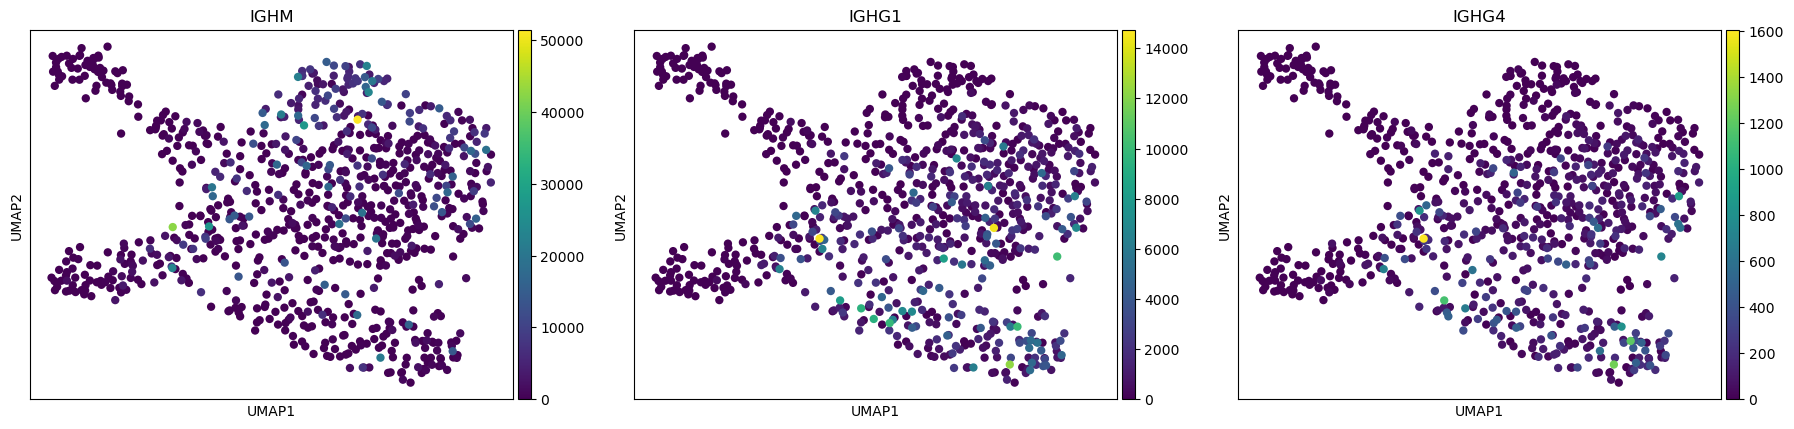

In [10]:
sc.pl.umap(adata, color=["IGHM","IGHG1","IGHG4",])


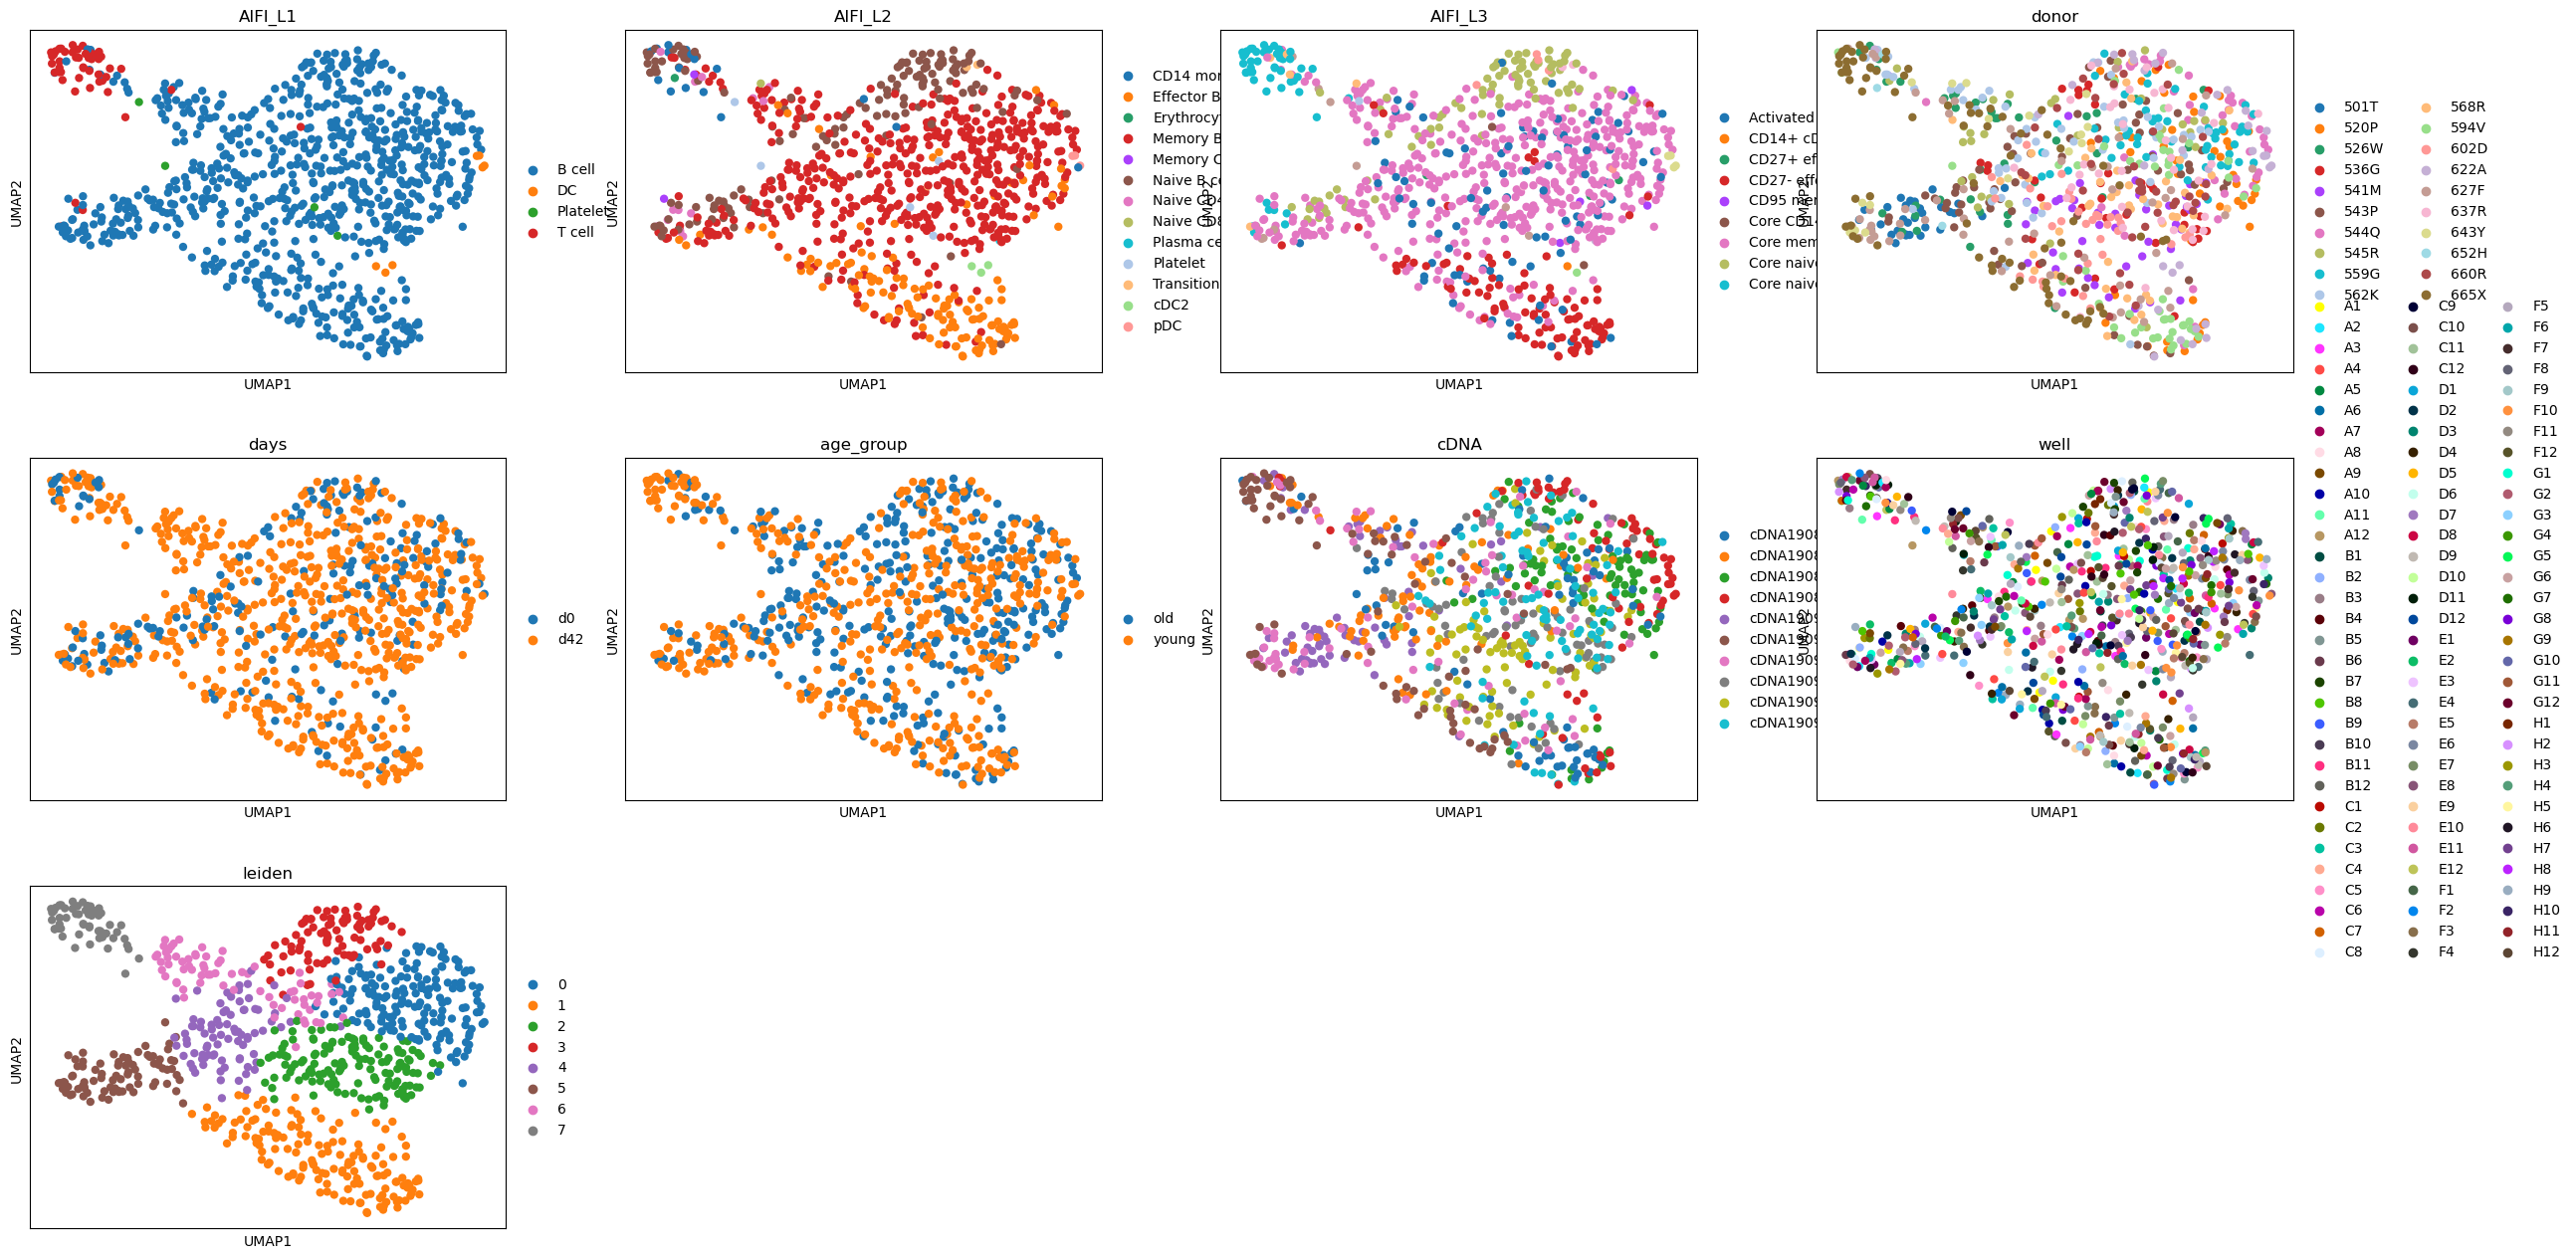

In [8]:
sc.pl.umap(adata, color=adata.obs.columns)


In [9]:
adata=adata[adata.obs["leiden"]!="7"]

In [10]:
adata=adata.raw.to_adata()
adata.raw=adata
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [11]:
%%time

sc.pp.highly_variable_genes(adata)
adata = adata[:, adata.var_names[adata.var['highly_variable']]]
sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=50,use_rep='X_pca', n_pcs=30)
sc.tl.umap(adata,min_dist=0.45,random_state=0)
sc.tl.leiden(adata,resolution=1.25,random_state=0)

/home/workspace/Aux_Envir/Python_BRI_Figures/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


CPU times: user 4min 39s, sys: 338 ms, total: 4min 39s
Wall time: 14.2 s


In [12]:
adata=adata.raw.to_adata()
adata.raw=adata
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

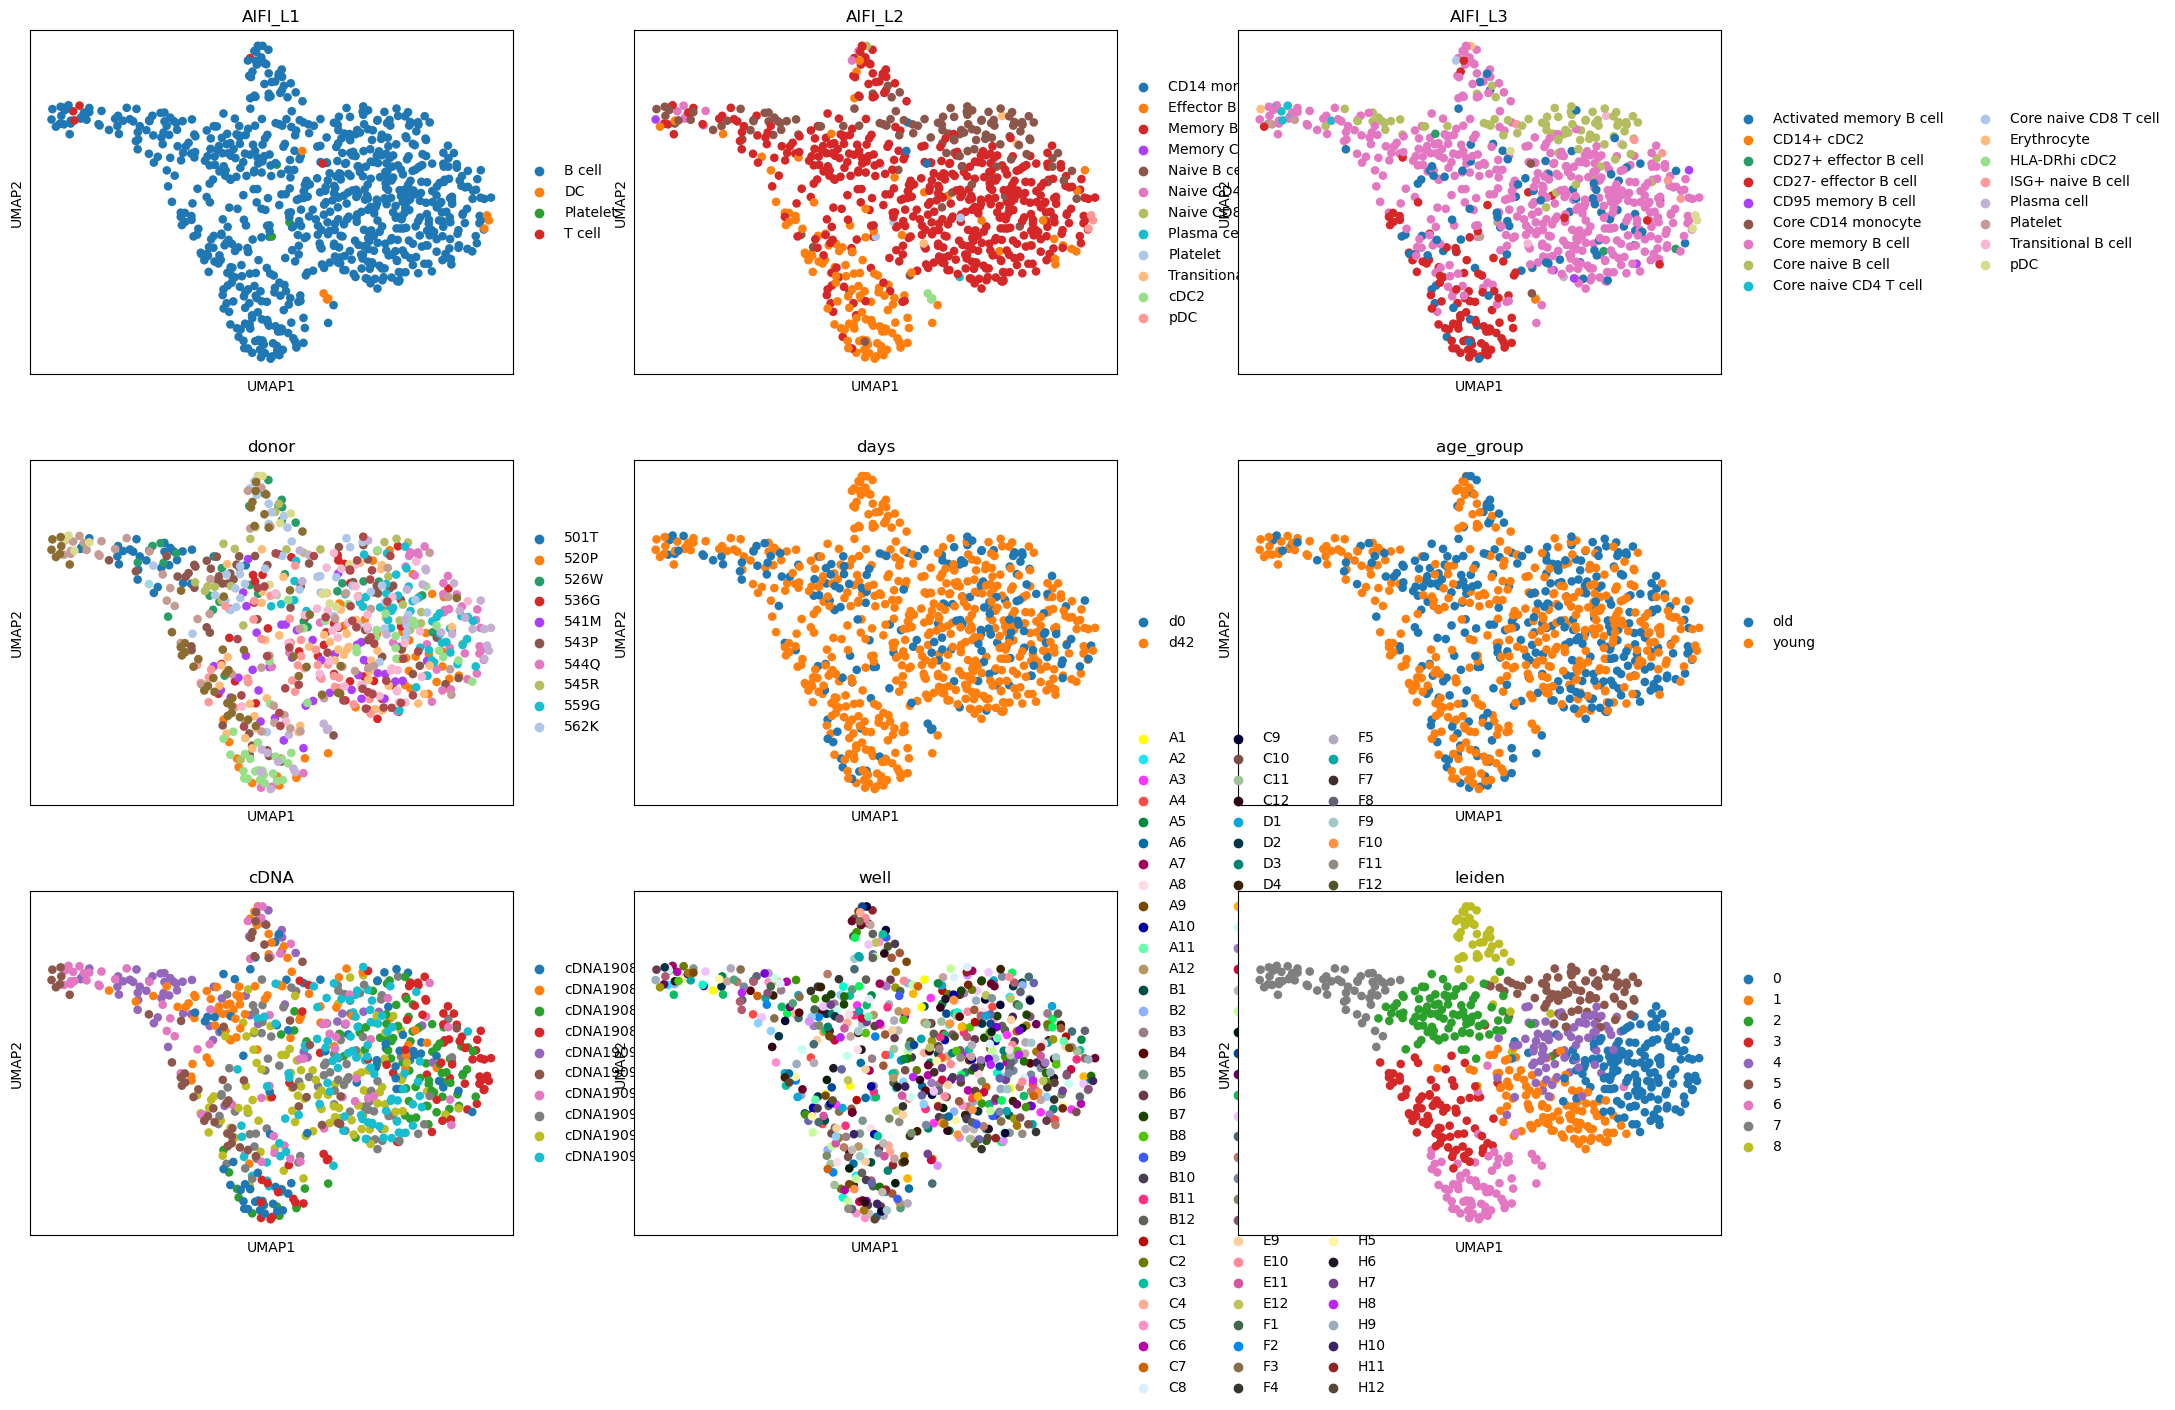

In [13]:
sc.pl.umap(adata, color=adata.obs.columns,ncols=3)


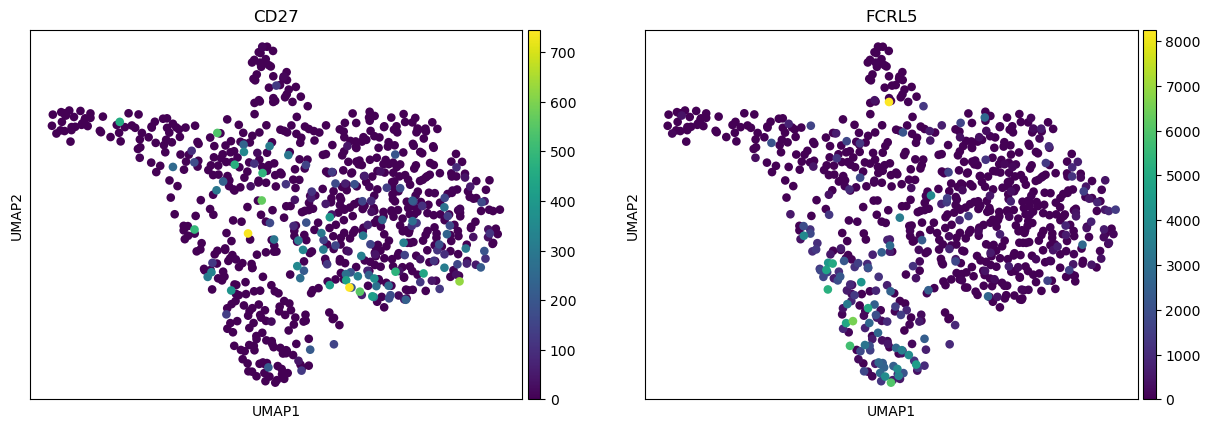

In [14]:
sc.pl.umap(adata, color=['CD27',"FCRL5"],ncols=3)


In [15]:
markers=["FCRL5",  "CD86", "TBX21","BCL6","PRDM1",
         "PAX5","XRCC6","AICDA","CCR7", "SELL", "CXCR4",
          "CXCR3","TNFRSF13B","FCER2", "CD27", "CD24"
]

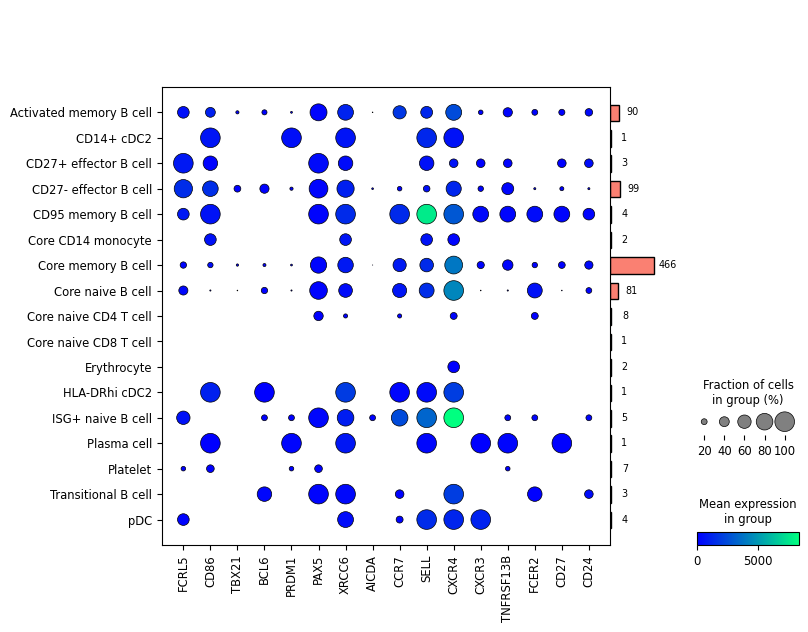

In [16]:
dp = sc.pl.dotplot(adata, markers, 'AIFI_L3', return_fig=True)
dp.add_totals().style(dot_edge_color='black', dot_edge_lw=0.5).show()

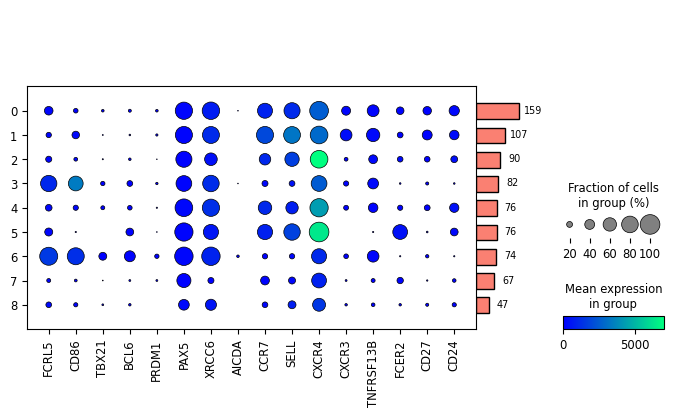

In [17]:
dp = sc.pl.dotplot(adata, markers, 'leiden', return_fig=True)
dp.add_totals().style(dot_edge_color='black', dot_edge_lw=0.5).show()

In [18]:
adata=adata.raw.to_adata()


In [19]:
adata.write_h5ad("adata_processed.h5ad")